<a href="https://colab.research.google.com/github/neilgautam/APRIORI-ASSOCIATION_RULE_LEARNING-/blob/master/APRIORI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import pylab
import datetime
from datetime import timedelta, date
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.cm as cm

In [2]:
def equipment_loader(file_path,equipments):
    equip_dict = {}
    for equipment in equipments:
#         print( file_path+equipment)
        equip_data = np.load(file_path+equipment)
        equipment = equipment[:-4]
        equip_dict[equipment] = list(equip_data)
    return equip_dict

In [3]:
def DayTimeGenerator():
    hour = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
    minute = ['00','30']
    second = '00'
    Time = []
    for hr in hour:
        for min in minute:
            temp = [hr,min,second]
            temp = ':'.join(temp)
            Time.append(temp)
    return Time

In [4]:
def get_equipment_list(path):
    equipment_list = []
    for item in os.listdir(path):
        if 'channel_' in item and item != "channel_1.dat":
            equipment_list.append(item)
    return equipment_list

In [5]:
def get_equipment_data(path, equipment_list):
    equipments_data = equipment_loader(path, equipment_list)
    return equipments_data

In [6]:
def get_all_time_of_day():
    Time = DayTimeGenerator()
    return Time

In [7]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [8]:
def get_min_max_dates(path_to_resampled_channel_data, number_of_channels):
    min_date = datetime.datetime.max.date()
    max_date = datetime.datetime.min.date()

    for i in reversed(range(2,number_of_channels)):
        cd = np.load(path_to_resampled_channel_data + "channel_"+str(i)+".npy")
        for item in cd:
            if(item != '0'):
                datetime_obj = datetime.datetime.strptime(item, "%Y-%m-%d %H:%M:%S")
                temp_date = datetime_obj.date()
                if(temp_date < min_date):
                    min_date = temp_date
                break;

        for item in reversed(cd):
            if(item != '0'):
                datetime_obj = datetime.datetime.strptime(item, "%Y-%m-%d %H:%M:%S")
                temp_date = datetime_obj.date()
                if(temp_date > max_date):
                    max_date = temp_date
                break;
    return min_date, max_date

In [9]:
def get_dates_list(min_date, max_date):
    Dates = []
    start_dt = min_date
    end_dt = max_date
    for dt in daterange(start_dt, end_dt):
        Dates.append(dt.strftime("%Y-%m-%d"))
    return Dates

In [10]:
def get_equipment_data_dic(equipment_list, equipments_data, Dates, Time):
    """
    Create an appliance usage dictionary for each day.
    
    equipment_dict[equipment] = 
    [
    [1, 0, 0, 1, 0, 1, 0, 1, 1, 1, ... , 0],
    [0, 1, 0, 1, 1, 1, 0, 1, 1, 0, ... , 0],
    .
    .
    .
    [1, 1, 1, 1, 0, 0, 0, 1, 0, 1, ... , 1]
    ]
    
    Where: 
    len(equipment_dict) = Total number of days 
    length of each value of the dictionary = 48
    """
    equipment_dict = {}
    for equipment in equipment_list:
        equipment = equipment[:-4]
        equipment_dict[equipment] = []
        for date in Dates:
            equipment_data_per_day = []
            for time in Time:
                temp_list = [date,time]
                temp_time = ' '.join(temp_list)
                if(temp_time in equipments_data[equipment]):
                    equipment_data_per_day.append(1)
                else:
                    equipment_data_per_day.append(0)
            equipment_dict[equipment].append(equipment_data_per_day)
    return equipment_dict

In [11]:
def get_tsne_input(equipment_dict):
    """
    
    Equipments | Time (48 timestamps)
    (many days)| 00:00:00 | 00:30:00 | 01:00:00 | ........ | 23:30:00 |
    ___________|__________|____________________________________________
               |
    equipment_1|    1     |    0     |    0     | ........ |     0    |
    equipment_1|    1     |    0     |    1     | ........ |     0    |
    equipment_2|    0     |    1     |    1     | ........ |     1    |
    equipment_2|    0     |    0     |    0     | ........ |     1    |
    equipment_3|    1     |    1     |    0     | ........ |     0    |
    equipment_3|    0     |    0     |    1     | ........ |     1    |

    
    """
    tsne_input = []
    labels = []
    for key in equipment_dict.keys():
        for data in np.array(equipment_dict[key]):
            labels.append(float(key.split('_')[1]))
            tsne_input.append(np.array(data).astype(np.float))
    return labels, tsne_input

In [12]:
def get_time_columns(Time):
    columns = []
    for time in Time:
        columns.append(time)
    return columns

In [16]:
def get_graph_labels(channel_list, labels):
    number_list = [x for x in range(1,len(channel_list))]
    channel_labels = []
    for item in labels:
        if(item in number_list):
            channel_labels.append(channel_list[int(item)-1])
    return channel_labels

In [19]:
def plot_clusters_using_tsne(path, channel_list, markers, graph_l, graph_h):
    # Get equipment list and data from channel files
    equipment_list = get_equipment_list(path)
    equipments_data = get_equipment_data(path, equipment_list)
    
    number_of_channels = len(channel_list)
    
    # Get max and min date in the equipments data
    min_date, max_date = get_min_max_dates(path, number_of_channels)

    # Generate date and time list 
    Dates = get_dates_list(min_date, max_date)
    Time = get_all_time_of_day()

    # Generate TSNE input data
    equipment_dict = get_equipment_data_dic(equipment_list, equipments_data, Dates, Time)
    labels, tsne_input = get_tsne_input(equipment_dict)

    # Generate column list
    columns = get_time_columns(Time)

    # Generate labels for graph legend 
    channel_labels = get_graph_labels(channel_list, labels)

    # Apply TSNE to generate 2-D output
    model = TSNE(n_components = 2, random_state = 0)
    tsne_data = model.fit_transform(tsne_input)
    tsne_data = np.vstack((tsne_data.T, labels)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns = ("D1", "D2", "Labels"))

    # Plotting the graph
    fig_dims = (graph_l, graph_h)
    fig, ax = plt.subplots(figsize=fig_dims)
    
    for g, m in zip(np.unique(labels), markers[:len(channel_list)]):
#         if(g == 4.0 or g == 5.0 or g == 6.0 ):
        ix = np.where(labels == g)
        ax.scatter(tsne_df[tsne_df["Labels"]==g]['D1'], tsne_df[tsne_df["Labels"]==g]['D2'], label = g, s =30, marker = m)

    ax.legend(channel_list[1:], fontsize= 'medium', loc = 'upper right')
    ax.plot()

In [22]:
#### HAS TO BE REMOVED!!!!!

# Get equipment list and data from channel files
equipment_list = get_equipment_list(path)
equipments_data = get_equipment_data(path, equipment_list)

number_of_channels = len(channel_list)

# Get max and min date in the equipments data
min_date, max_date = get_min_max_dates(path, number_of_channels)

# Generate date and time list 
Dates = get_dates_list(min_date, max_date)
Time = get_all_time_of_day()

# Generate TSNE input data
equipment_dict = get_equipment_data_dic(equipment_list, equipments_data, Dates, Time)
labels, tsne_input = get_tsne_input(equipment_dict)

# Generate column list
columns = get_time_columns(Time)

# Generate labels for graph legend 
channel_labels = get_graph_labels(channel_list, labels)

# Apply TSNE to generate 2-D output
model = TSNE(n_components = 2, random_state = 0)
tsne_data = model.fit_transform(tsne_input)
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns = ("D1", "D2", "Labels"))

In [32]:
min(tsne_df['Labels'])

2.0

[]

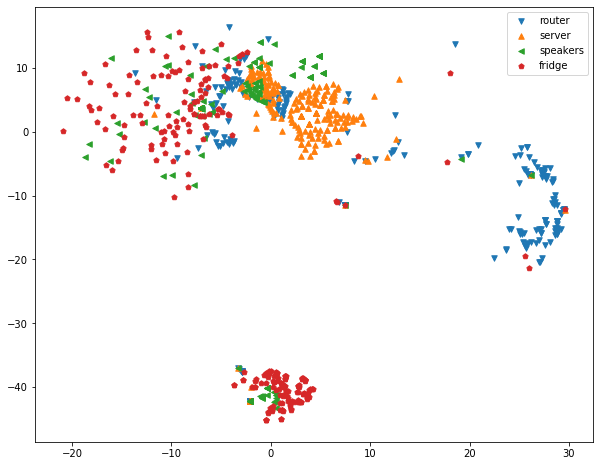

In [83]:
graph_l = 10
graph_h = 8
markers=[',','o','v','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d','|','_']
descriptions=['pixel', 'circle', 'triangle_down', 'triangle_up','triangle_left', 'triangle_right', 'tri_down', 'tri_up', 'tri_left','tri_right', 'octagon', 'square', 'pentagon', 'plus (filled)','star', 'hexagon1', 'hexagon2', 'plus', 'x', 'x (filled)','diamond', 'thin_diamond', 'vline', 'hline']

path = "../Utils/Channel_On_Off_data/House_2/"
channel_list = ["aggregate", "laptop", "monitor", "speakers", "server", "router", "server_hdd", "kettle", "rice_cooker", "running_machine", "laptop2", "washing_machine", "dish_washer", "fridge", "microwave", "toaster", "playstation", "modem", "cooker"]

selected_channels = ["router", "server", "speakers", "fridge"]
channel_id_list = [float(i+1) for i in [channel_list.index(item) for item in selected_channels]]

# Plotting the graph
fig_dims = (graph_l, graph_h)
fig, ax = plt.subplots(figsize=fig_dims)

for g, m in zip(np.unique(labels), markers[:len(channel_list)]):
        if(g in channel_id_list):
            ix = np.where(labels == g)
            ax.scatter(tsne_df[tsne_df["Labels"]==g]['D1'], tsne_df[tsne_df["Labels"]==g]['D2'], label = g, s =30, marker = m)

label_list = []
for channel_id in channel_id_list:
    label_list.append(channel_list[int(channel_id)-1])

ax.legend(label_list, fontsize= 'medium', loc = 'upper right')
ax.plot()

[]

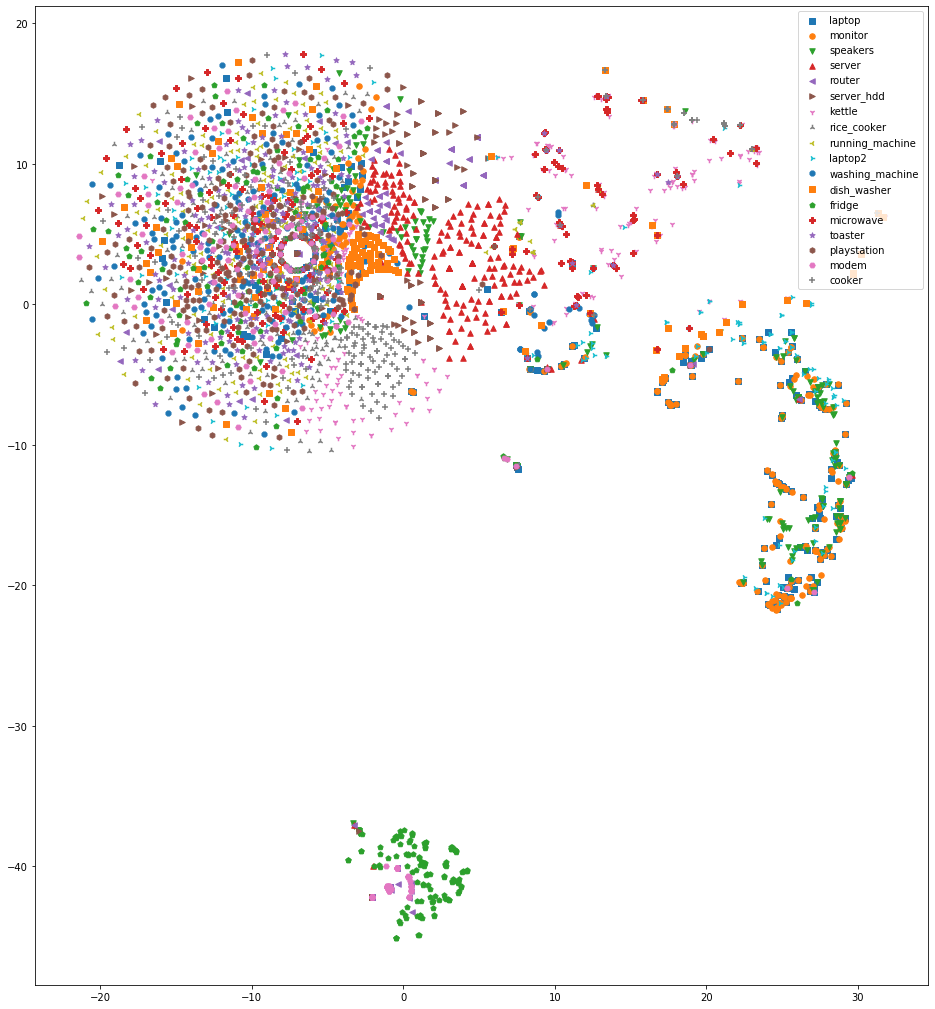

In [56]:
graph_l = 16
graph_h = 18
markers=[',','o','v','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d','|','_']
descriptions=['pixel', 'circle', 'triangle_down', 'triangle_up','triangle_left', 'triangle_right', 'tri_down', 'tri_up', 'tri_left','tri_right', 'octagon', 'square', 'pentagon', 'plus (filled)','star', 'hexagon1', 'hexagon2', 'plus', 'x', 'x (filled)','diamond', 'thin_diamond', 'vline', 'hline']

path = "../Utils/Channel_On_Off_data/House_2/"
channel_list = ["aggregate", "laptop", "monitor", "speakers", "server", "router", "server_hdd", "kettle", "rice_cooker", "running_machine", "laptop2", "washing_machine", "dish_washer", "fridge", "microwave", "toaster", "playstation", "modem", "cooker"]

selected_channels = ["laptop", "monitor", "speakers", "server", "router", "server_hdd", "kettle", "rice_cooker", "running_machine", "laptop2", "washing_machine", "dish_washer", "fridge", "microwave", "toaster", "playstation", "modem", "cooker"]
channel_id_list = [float(i+1) for i in [channel_list.index(item) for item in selected_channels]]

# Plotting the graph
fig_dims = (graph_l, graph_h)
fig, ax = plt.subplots(figsize=fig_dims)

for g, m in zip(np.unique(labels), markers[:len(channel_list)]):
        if(g in channel_id_list):
            ix = np.where(labels == g)
            ax.scatter(tsne_df[tsne_df["Labels"]==g]['D1'], tsne_df[tsne_df["Labels"]==g]['D2'], label = g, s =30, marker = m)

label_list = []
for channel_id in channel_id_list:
    label_list.append(channel_list[int(channel_id)-1])

ax.legend(label_list, fontsize= 'medium', loc = 'upper right')
ax.plot()

[]

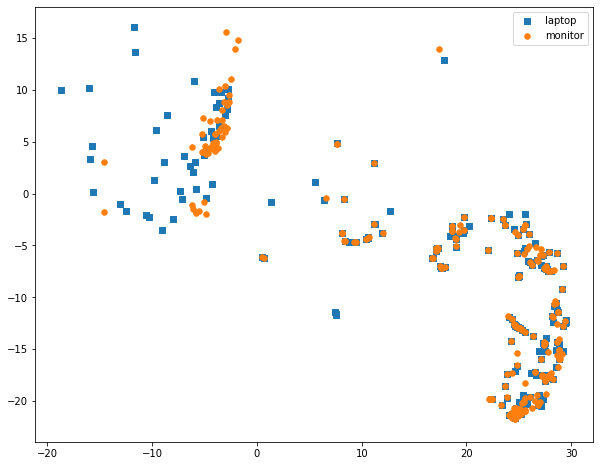

In [82]:
graph_l = 10
graph_h = 8
markers=[',','o','v','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d','|','_']
descriptions=['pixel', 'circle', 'triangle_down', 'triangle_up','triangle_left', 'triangle_right', 'tri_down', 'tri_up', 'tri_left','tri_right', 'octagon', 'square', 'pentagon', 'plus (filled)','star', 'hexagon1', 'hexagon2', 'plus', 'x', 'x (filled)','diamond', 'thin_diamond', 'vline', 'hline']

path = "../Utils/Channel_On_Off_data/House_2/"
channel_list = ["aggregate", "laptop", "monitor", "speakers", "server", "router", "server_hdd", "kettle", "rice_cooker", "running_machine", "laptop2", "washing_machine", "dish_washer", "fridge", "microwave", "toaster", "playstation", "modem", "cooker"]

selected_channels = ["laptop", "monitor"]
channel_id_list = [float(i+1) for i in [channel_list.index(item) for item in selected_channels]]

# Plotting the graph
fig_dims = (graph_l, graph_h)
fig, ax = plt.subplots(figsize=fig_dims)

for g, m in zip(np.unique(labels), markers[:len(channel_list)]):
        if(g in channel_id_list):
            ix = np.where(labels == g)
            ax.scatter(tsne_df[tsne_df["Labels"]==g]['D1'], tsne_df[tsne_df["Labels"]==g]['D2'], label = g, s =30, marker = m)

label_list = []
for channel_id in channel_id_list:
    label_list.append(channel_list[int(channel_id)-1])

ax.legend(label_list, fontsize= 'medium', loc = 'upper right')
ax.plot()

[]

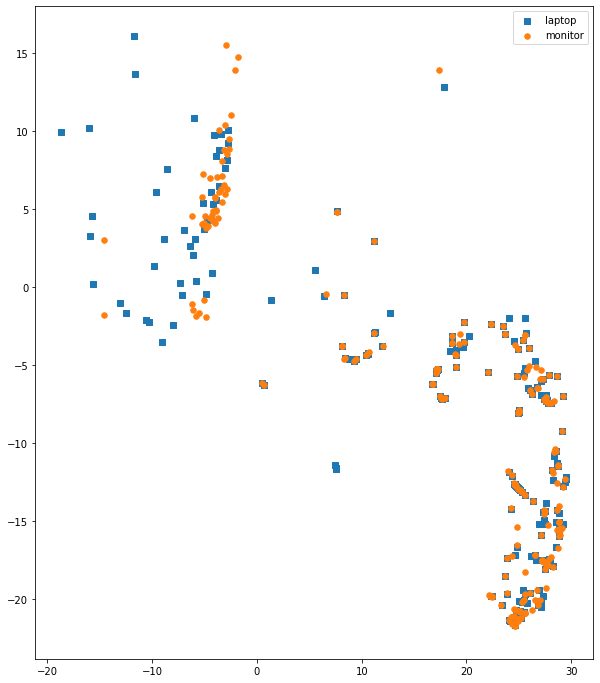

In [74]:
graph_l = 10
graph_h = 12
markers=[',','o','v','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d','|','_']
descriptions=['pixel', 'circle', 'triangle_down', 'triangle_up','triangle_left', 'triangle_right', 'tri_down', 'tri_up', 'tri_left','tri_right', 'octagon', 'square', 'pentagon', 'plus (filled)','star', 'hexagon1', 'hexagon2', 'plus', 'x', 'x (filled)','diamond', 'thin_diamond', 'vline', 'hline']

path = "../Utils/Channel_On_Off_data/House_2/"
channel_list = ["aggregate", "laptop", "monitor", "speakers", "server", "router", "server_hdd", "kettle", "rice_cooker", "running_machine", "laptop2", "washing_machine", "dish_washer", "fridge", "microwave", "toaster", "playstation", "modem", "cooker"]

selected_channels = ["laptop", "monitor"]
channel_id_list = [float(i+1) for i in [channel_list.index(item) for item in selected_channels]]

# Plotting the graph
fig_dims = (graph_l, graph_h)
fig, ax = plt.subplots(figsize=fig_dims)

for g, m in zip(np.unique(labels), markers[:len(channel_list)]):
        if(g in channel_id_list):
            ix = np.where(labels == g)
            ax.scatter(tsne_df[tsne_df["Labels"]==g]['D1'], tsne_df[tsne_df["Labels"]==g]['D2'], label = g, s =30, marker = m)

label_list = []
for channel_id in channel_id_list:
    label_list.append(channel_list[int(channel_id)-1])

ax.legend(label_list, fontsize= 'medium', loc = 'upper right')
ax.plot()

In [21]:
# HOUSE 2 AFTER KMEANS

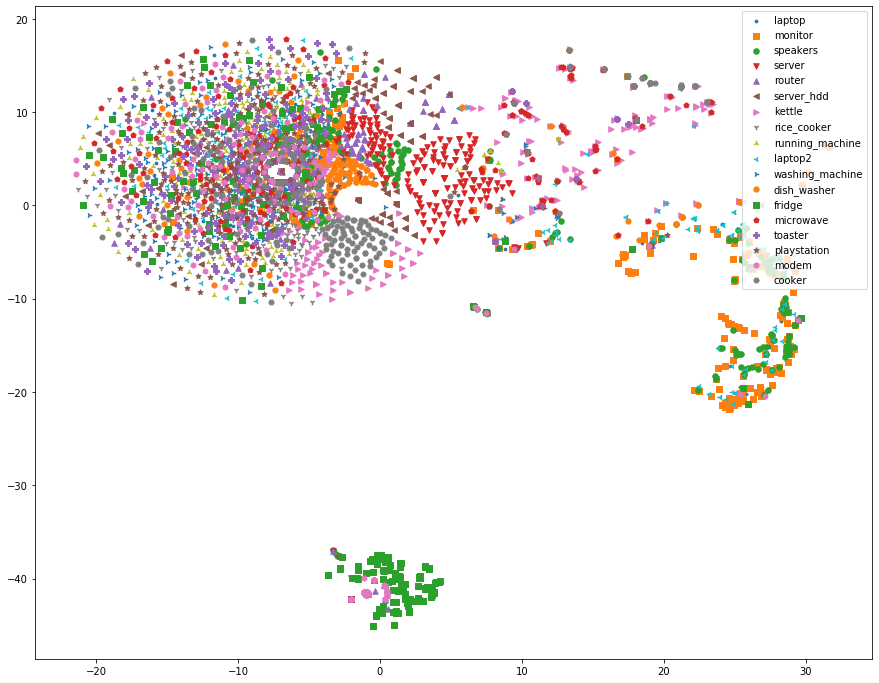

In [20]:
markers=['.',',','o','v','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d','|','_']
descriptions=['point', 'pixel', 'circle', 'triangle_down', 'triangle_up','triangle_left', 'triangle_right', 'tri_down', 'tri_up', 'tri_left','tri_right', 'octagon', 'square', 'pentagon', 'plus (filled)','star', 'hexagon1', 'hexagon2', 'plus', 'x', 'x (filled)','diamond', 'thin_diamond', 'vline', 'hline']

path = "../Utils/Channel_On_Off_data/House_2/"
channel_list = ["aggregate", "laptop", "monitor", "speakers", "server", "router", "server_hdd", "kettle", "rice_cooker", "running_machine", "laptop2", "washing_machine", "dish_washer", "fridge", "microwave", "toaster", "playstation", "modem", "cooker"]

plot_clusters_using_tsne(path, channel_list, markers, 15, 12)

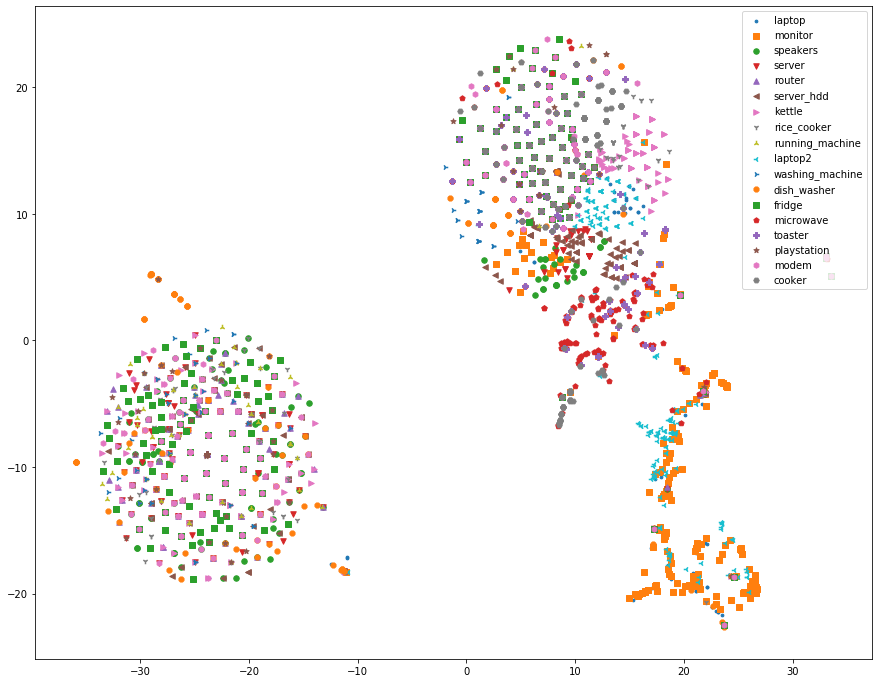

In [185]:
# markers=['.',',','o','v','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d','|','_']
# descriptions=['point', 'pixel', 'circle', 'triangle_down', 'triangle_up','triangle_left', 'triangle_right', 'tri_down', 'tri_up', 'tri_left','tri_right', 'octagon', 'square', 'pentagon', 'plus (filled)','star', 'hexagon1', 'hexagon2', 'plus', 'x', 'x (filled)','diamond', 'thin_diamond', 'vline', 'hline']

# path = "./Channel_On_Off_data/House_2/"
# channel_list = ["aggregate", "laptop", "monitor", "speakers", "server", "router", "server_hdd", "kettle", "rice_cooker", "running_machine", "laptop2", "washing_machine", "dish_washer", "fridge", "microwave", "toaster", "playstation", "modem", "cooker"]

# plot_clusters_using_tsne(path, channel_list, markers, 15, 12)

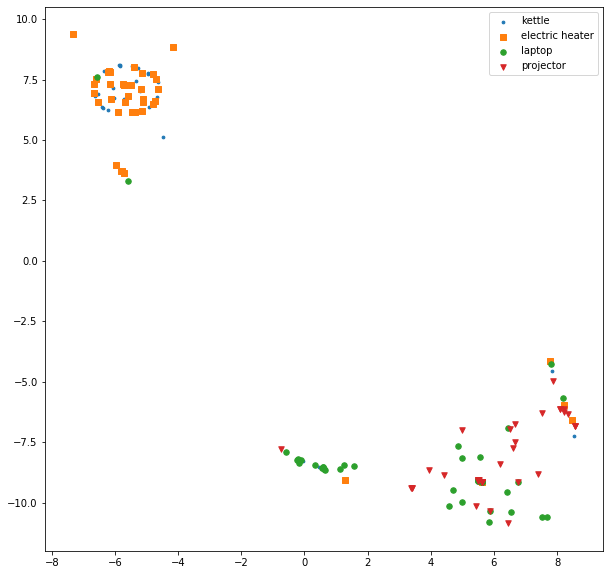

In [187]:
markers=['.',',','o','v','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d','|','_']
descriptions=['point', 'pixel', 'circle', 'triangle_down', 'triangle_up','triangle_left', 'triangle_right', 'tri_down', 'tri_up', 'tri_left','tri_right', 'octagon', 'square', 'pentagon', 'plus (filled)','star', 'hexagon1', 'hexagon2', 'plus', 'x', 'x (filled)','diamond', 'thin_diamond', 'vline', 'hline']

path = "./Channel_On_Off_data/House_3/"
channel_list = ["aggregate", "kettle", "electric heater", "laptop", "projector"]

plot_clusters_using_tsne(path, channel_list, markers, 10, 10)

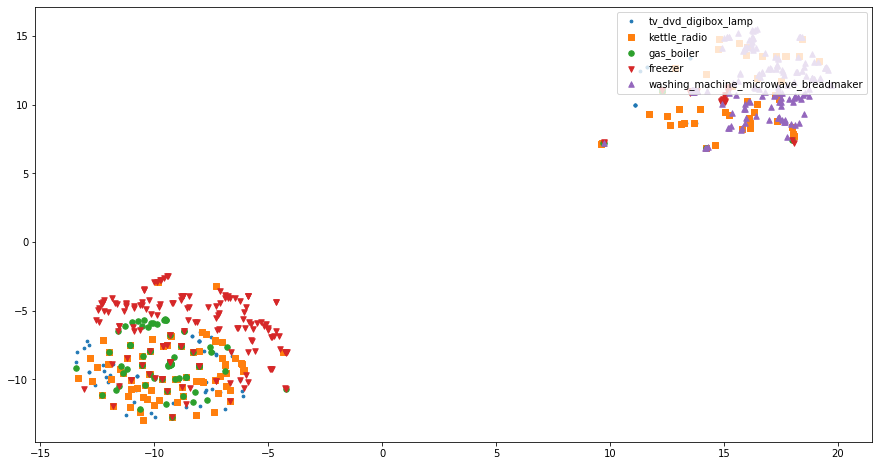

In [189]:
markers=['.',',','o','v','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d','|','_']
descriptions=['point', 'pixel', 'circle', 'triangle_down', 'triangle_up','triangle_left', 'triangle_right', 'tri_down', 'tri_up', 'tri_left','tri_right', 'octagon', 'square', 'pentagon', 'plus (filled)','star', 'hexagon1', 'hexagon2', 'plus', 'x', 'x (filled)','diamond', 'thin_diamond', 'vline', 'hline']

path = "./Channel_On_Off_data/House_4/"
channel_list = ["aggregate", "tv_dvd_digibox_lamp", "kettle_radio", "gas_boiler", "freezer", "washing_machine_microwave_breadmaker"]

plot_clusters_using_tsne(path, channel_list, markers, 15, 8)

[]

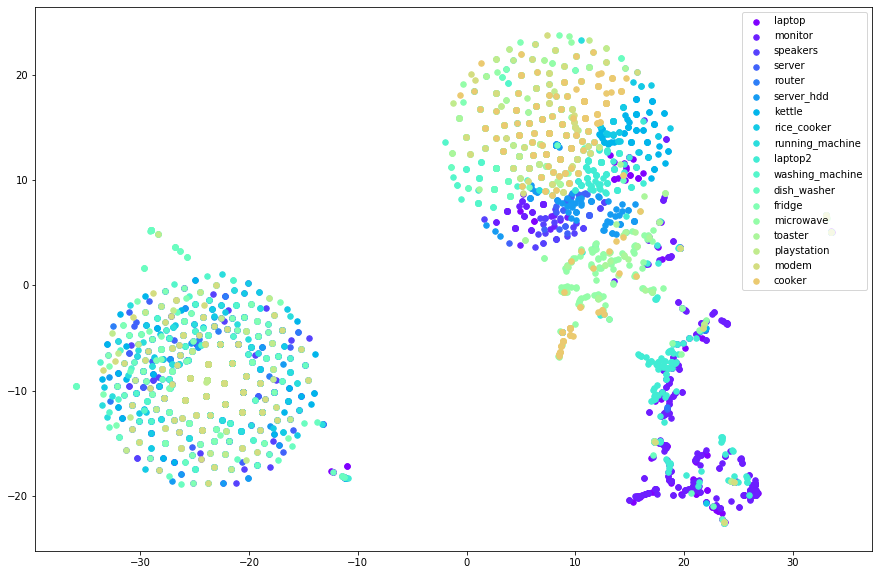

In [179]:
# # Plotting the graph
# colors = cm.rainbow(np.linspace(0, 0.75, len(channel_list)))
# fig_dims = (15, 10)
# fig, ax = plt.subplots(figsize=fig_dims)

# for g, color in zip(np.unique(labels), colors):
#     ix = np.where(labels == g)
# #         print(g)
#     ax.scatter(tsne_df[tsne_df["Labels"]==g]['D1'], tsne_df[tsne_df["Labels"]==g]['D2'], label = g, s =30, color=color)

# ax.legend(channel_list[1:], fontsize= 'medium', loc = 'upper right')
# ax.plot()

[]

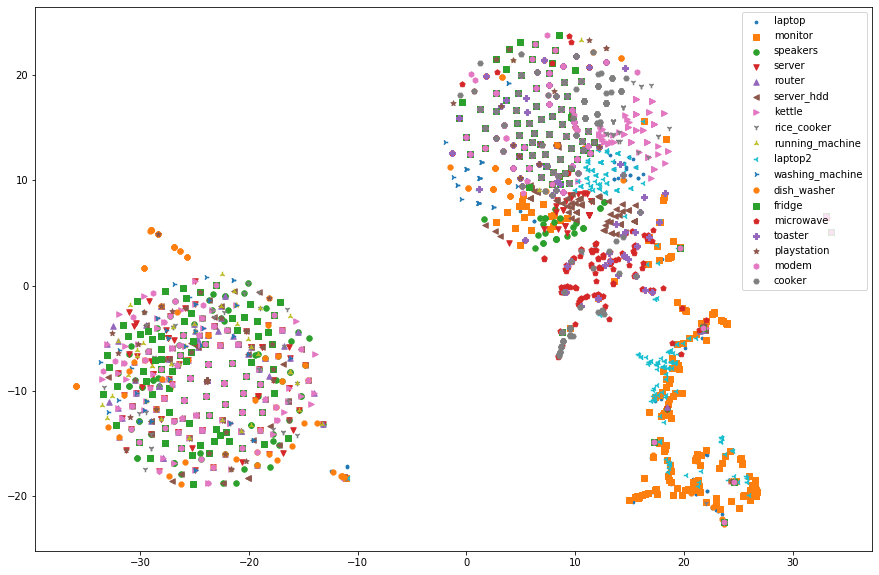

In [180]:
# markers=['.',',','o','v','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d','|','_']
# descriptions=['point', 'pixel', 'circle', 'triangle_down', 'triangle_up','triangle_left', 'triangle_right', 'tri_down', 'tri_up', 'tri_left','tri_right', 'octagon', 'square', 'pentagon', 'plus (filled)','star', 'hexagon1', 'hexagon2', 'plus', 'x', 'x (filled)','diamond', 'thin_diamond', 'vline', 'hline']


# # Plotting the graph
# colors = cm.rainbow(np.linspace(0, 0.75, len(channel_list)))
# fig_dims = (15, 10)
# fig, ax = plt.subplots(figsize=fig_dims)

# for g, m in zip(np.unique(labels), markers[:len(channel_list)]):
#     ix = np.where(labels == g)
# #         print(g)
#     ax.scatter(tsne_df[tsne_df["Labels"]==g]['D1'], tsne_df[tsne_df["Labels"]==g]['D2'], label = g, s =30, marker = m)

# ax.legend(channel_list[1:], fontsize= 'medium', loc = 'upper right')
# ax.plot()

[]

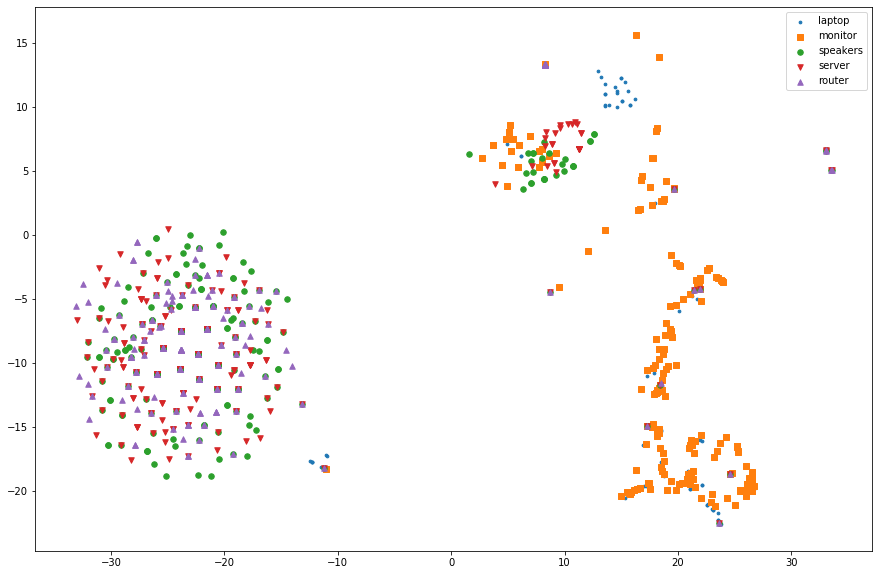

In [197]:
# Plotting the graph
fig_dims = (15, 10)
fig, ax = plt.subplots(figsize=fig_dims)

for g, m in zip(np.unique(labels), markers[:len(channel_list)]):
    if(int(g) in range(2,7)):
        ix = np.where(labels == g)
        ax.scatter(tsne_df[tsne_df["Labels"]==g]['D1'], tsne_df[tsne_df["Labels"]==g]['D2'], label = g, s =30, marker = m)

ax.legend(channel_list[1:8], fontsize= 'medium', loc = 'upper right')
ax.plot()

[]

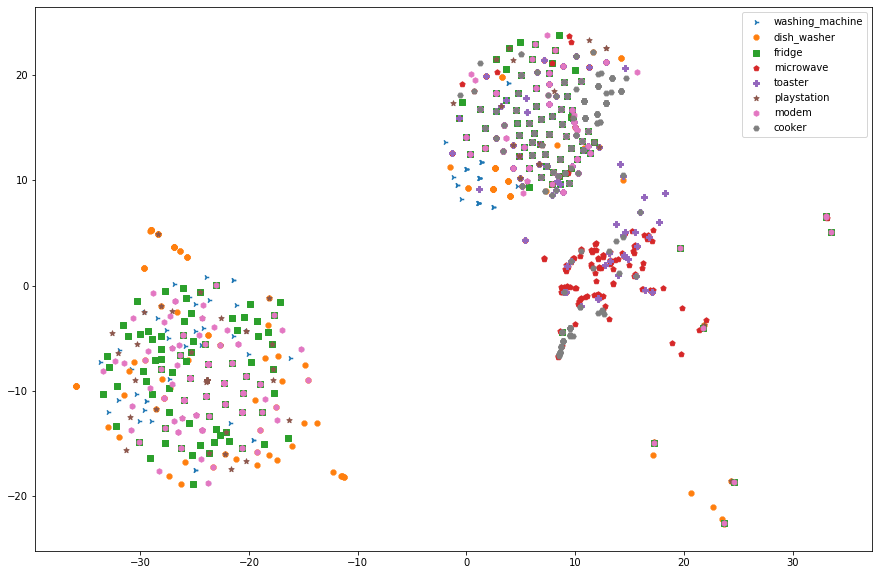

In [196]:
# Plotting the graph
fig_dims = (15, 10)
fig, ax = plt.subplots(figsize=fig_dims)

for g, m in zip(np.unique(labels), markers[:len(channel_list)]):
    if(int(g) in range(12,20)):
        ix = np.where(labels == g)
        ax.scatter(tsne_df[tsne_df["Labels"]==g]['D1'], tsne_df[tsne_df["Labels"]==g]['D2'], label = g, s =30, marker = m)

ax.legend(channel_list[11:], fontsize= 'medium', loc = 'upper right')
ax.plot()